In [51]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from OurRandomForest import OurRandomForest
from OurFastRandomForest import OurFastRandomForest
from FastRandomForest import FastRandomForest


from tqdm import tqdm, trange
from sklearn.datasets import make_classification
import itertools


In [7]:
# -------------------------
# Exemplo de uso
# -------------------------

from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris

data = load_iris()
X, y = data.data, data.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

clf = OurRandomForest(n_trees=10000, max_depth=5, n_jobs = 16)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

acc = np.mean(y_pred == y_test)
print(f"Acurácia: {acc:.4f}")


Acurácia: 1.0000


In [9]:
import time
### A function to benchmark a implementation of rf:
def benchmark_rf(clf, X, y, n_tests=5, test_size=0.3):
    from sklearn.model_selection import train_test_split
    from sklearn.metrics import accuracy_score

    accuracies = []
    train_times = []
    test_times = []
    for i in range(n_tests):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=i)
        model = clf
        
        ### Training
        start = time.time()
        model.fit(X_train, y_train)
        train_times.append(time.time() - start)
        
        ### Testing
        start = time.time()
        y_pred = model.predict(X_test)
        test_times.append(time.time() - start)
        acc = accuracy_score(y_test, y_pred)
        accuracies.append(acc)
        
    
    return pd.DataFrame({
        'implementation': [clf.__class__.__name__]*n_tests,
        'n_features': [X.shape[1]]*n_tests,
        'n_samples': [X.shape[0]]*n_tests,
        'seed': list(range(n_tests)),
        'accuracy': accuracies,
        'train_time': train_times,
        'test_time': test_times})

### Variando Número de Samples

In [ ]:

final = None

features_interval = range(20,21)
#samples_interval = range(100, 2001, 100)
samples_interval = range(2100, 4001, 100)
n_tests = range(5)
n_jobs = 12

tests = [{"features": features_interval, "samples": samples_interval, "n_test":n_test} for features_interval, samples_interval, n_test in list(itertools.product(features_interval, samples_interval, n_tests))]
shuffle = True
if shuffle:
    np.random.shuffle(tests)

for test in tqdm(tests):
    features = test["features"]
    samples = test["samples"]
    n_test = test["n_test"]
    # Create syntetic dataset using scikit
    data = make_classification(n_samples=samples, n_features=features, n_informative=int(features*0.5), n_redundant=int(features*0.25), n_clusters_per_class=2, random_state=n_test,)
    X, y = data
    results = [#benchmark_rf(OurRandomForest(n_trees=100, max_depth=7, max_features=None, n_jobs=n_jobs), X, y, n_tests=1),
               benchmark_rf(OurFastRandomForest(n_trees=100, max_depth=7, max_features=None, n_jobs=n_jobs), X, y, n_tests=1),
               benchmark_rf(FastRandomForest(n_trees=100, max_depth=7, max_features=None, n_jobs=n_jobs), X, y, n_tests=1),
               benchmark_rf(RandomForestClassifier(n_estimators=100, max_depth=7, max_features=None, n_jobs=n_jobs), X, y, n_tests=1)
            ]

    final = pd.concat([final] + results, ignore_index=True)
            

100%|██████████| 100/100 [17:39<00:00, 10.59s/it]


In [31]:
tests = [{"features": features_interval, "samples": samples_interval, "n_tests":n_test} for features_interval, samples_interval, n_test in list(itertools.product(features_interval, samples_interval, n_tests))]
tests

[{'features': 20, 'samples': 2100, 'n_tests': 0},
 {'features': 20, 'samples': 2100, 'n_tests': 1},
 {'features': 20, 'samples': 2100, 'n_tests': 2},
 {'features': 20, 'samples': 2100, 'n_tests': 3},
 {'features': 20, 'samples': 2100, 'n_tests': 4},
 {'features': 20, 'samples': 2200, 'n_tests': 0},
 {'features': 20, 'samples': 2200, 'n_tests': 1},
 {'features': 20, 'samples': 2200, 'n_tests': 2},
 {'features': 20, 'samples': 2200, 'n_tests': 3},
 {'features': 20, 'samples': 2200, 'n_tests': 4},
 {'features': 20, 'samples': 2300, 'n_tests': 0},
 {'features': 20, 'samples': 2300, 'n_tests': 1},
 {'features': 20, 'samples': 2300, 'n_tests': 2},
 {'features': 20, 'samples': 2300, 'n_tests': 3},
 {'features': 20, 'samples': 2300, 'n_tests': 4},
 {'features': 20, 'samples': 2400, 'n_tests': 0},
 {'features': 20, 'samples': 2400, 'n_tests': 1},
 {'features': 20, 'samples': 2400, 'n_tests': 2},
 {'features': 20, 'samples': 2400, 'n_tests': 3},
 {'features': 20, 'samples': 2400, 'n_tests': 4},


In [32]:
final.to_csv('results/results_v22e.csv', index=False)

(0.0, 2000.0)

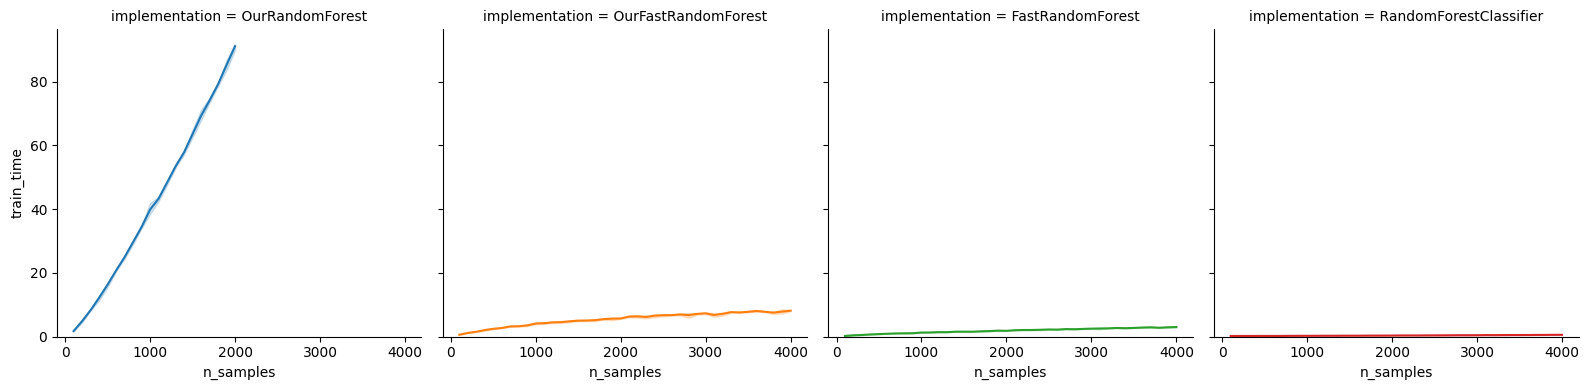

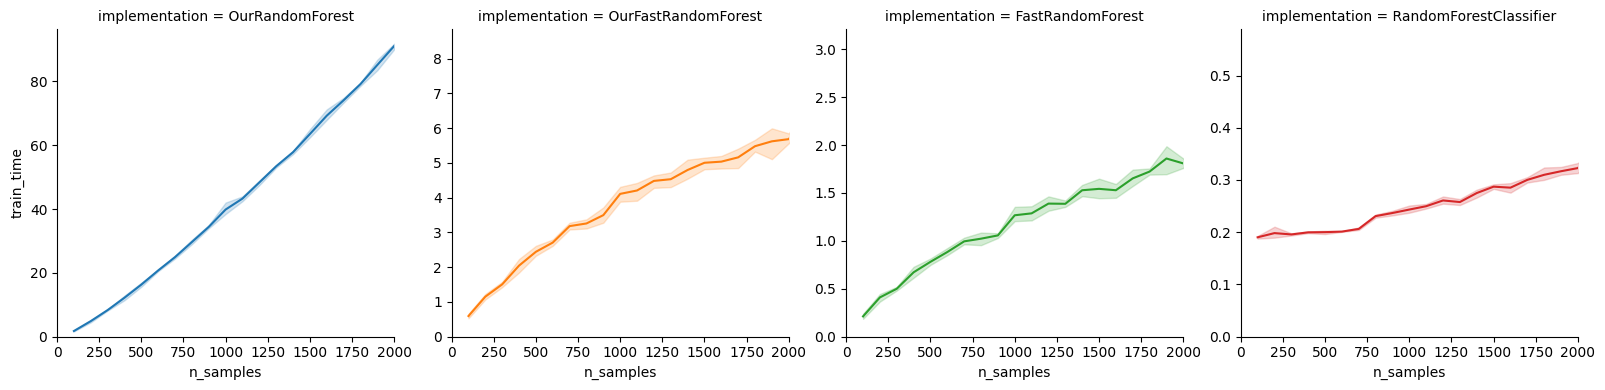

In [50]:
import seaborn as sns

results = pd.concat([pd.read_csv('results/results_v22.csv'), pd.read_csv('results/results_v22e.csv')], ignore_index=True)
g = sns.FacetGrid(data = results, col='implementation', sharey=True, height=4, hue='implementation')
g.map(sns.lineplot, 'n_samples', "train_time")

# Ensure each facet's y-axis starts at 0
for ax in g.axes.flatten():
    ax.set_ylim(bottom=0)


g = sns.FacetGrid(data = results, col='implementation', sharey='col', height=4, hue='implementation')
g.map(sns.lineplot, 'n_samples', "train_time")

# Ensure each facet's y-axis starts at 0
for ax in g.axes.flatten():
    ax.set_ylim(bottom=0)
g.axes.flatten()[0].set_xlim(0, 2000)

### Variando Número de Features

In [59]:
final = None

features_interval = range(20,501,20)
samples_interval = range(100, 101)
n_tests = range(5)
n_jobs = 12

tests = [{"features": features_interval, "samples": samples_interval, "n_test":n_test} for features_interval, samples_interval, n_test in list(itertools.product(features_interval, samples_interval, n_tests))]
shuffle = True
if shuffle:
    np.random.shuffle(tests)

for test in tqdm(tests):
    features = test["features"]
    samples = test["samples"]
    n_test = test["n_test"]
    # Create syntetic dataset using scikit
    data = make_classification(n_samples=samples, n_features=features, n_informative=int(features*0.5), n_redundant=int(features*0.25), n_clusters_per_class=2, random_state=n_test,)
    X, y = data
    results = [benchmark_rf(OurRandomForest(n_trees=100, max_depth=7, max_features=None, n_jobs=n_jobs), X, y, n_tests=1),
               benchmark_rf(OurFastRandomForest(n_trees=100, max_depth=7, max_features=None, n_jobs=n_jobs), X, y, n_tests=1),
               benchmark_rf(FastRandomForest(n_trees=100, max_depth=7, max_features=None, n_jobs=n_jobs), X, y, n_tests=1),
               benchmark_rf(RandomForestClassifier(n_estimators=100, max_depth=7, max_features=None, n_jobs=n_jobs), X, y, n_tests=1)
            ]

    final = pd.concat([final] + results, ignore_index=True)

100%|██████████| 125/125 [1:06:11<00:00, 31.77s/it]


In [60]:
final.to_csv('results/results_v23.csv', index=False)

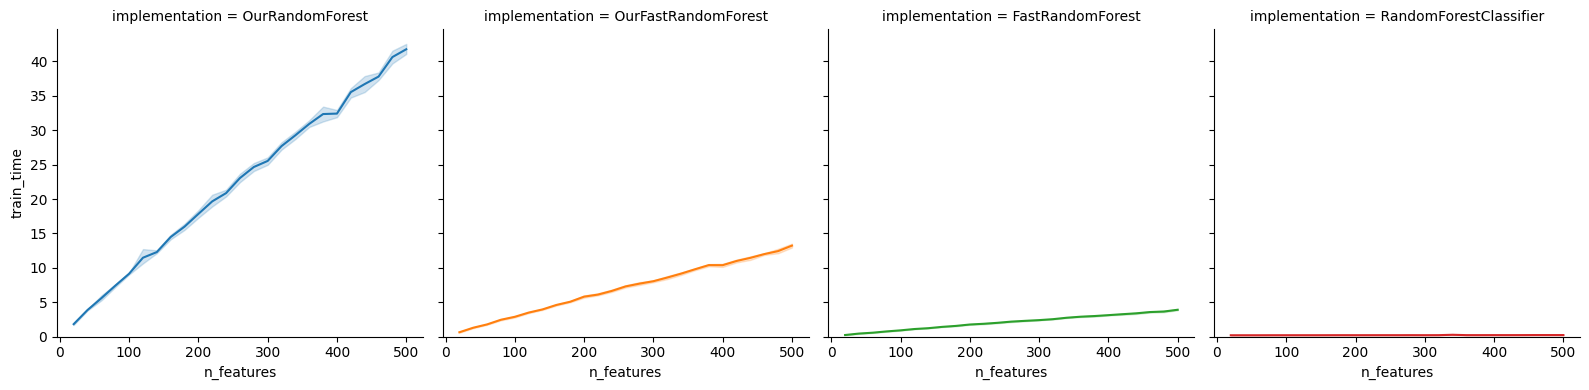

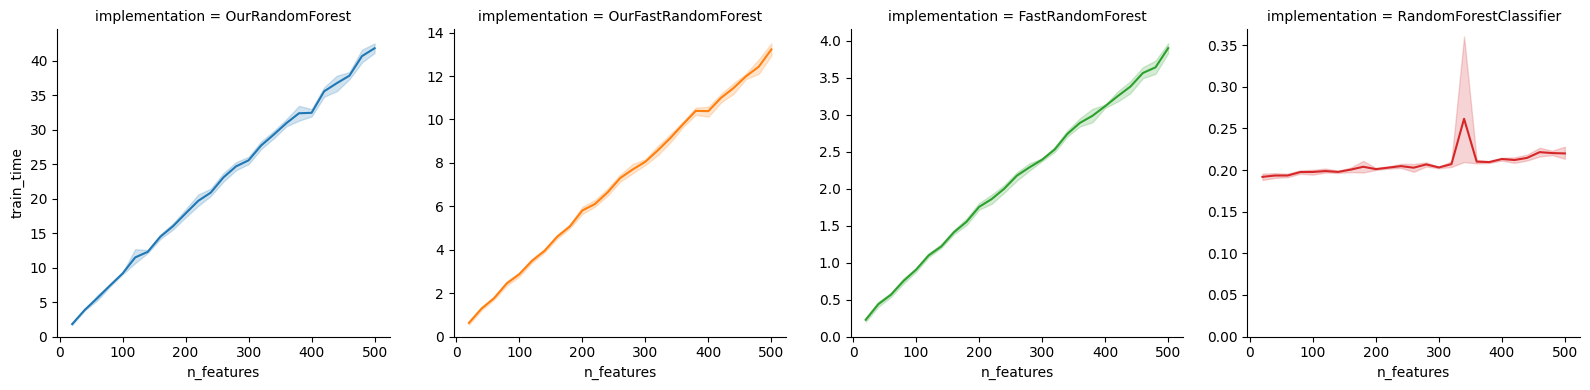

In [61]:
import seaborn as sns

results = pd.concat([pd.read_csv('results/results_v23.csv')])
g = sns.FacetGrid(data = results, col='implementation', sharey=True, height=4, hue='implementation')
g.map(sns.lineplot, 'n_features', "train_time")

# Ensure each facet's y-axis starts at 0
for ax in g.axes.flatten():
    ax.set_ylim(bottom=0)


g = sns.FacetGrid(data = results, col='implementation', sharey='col', height=4, hue='implementation')
g.map(sns.lineplot, 'n_features', "train_time")

# Ensure each facet's y-axis starts at 0
for ax in g.axes.flatten():
    ax.set_ylim(bottom=0)

In [54]:
sns.lineplot(data =results, x='n_features', y='train_time', hue='implementation').set_ylim(bottom=0)

TypeError: Data source must be a DataFrame or Mapping, not <class 'list'>.

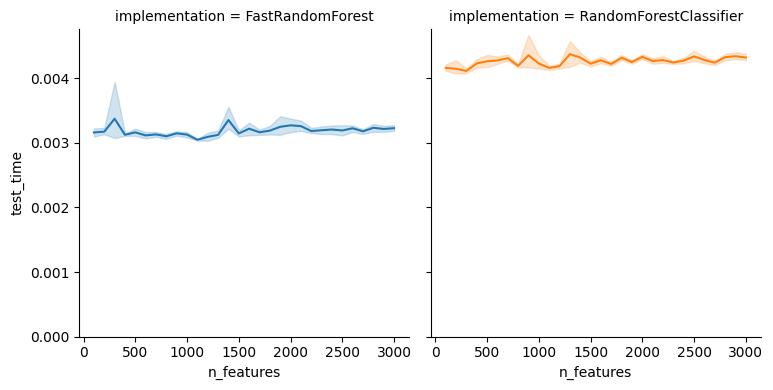

In [ ]:
import seaborn as sns

g = sns.FacetGrid(data = results, col='implementation', sharey=True, height=4, hue='implementation')
g.map(sns.lineplot, 'n_features',"test_time")

for ax in g.axes.flatten():
    ax.set_ylim(bottom=0.0)

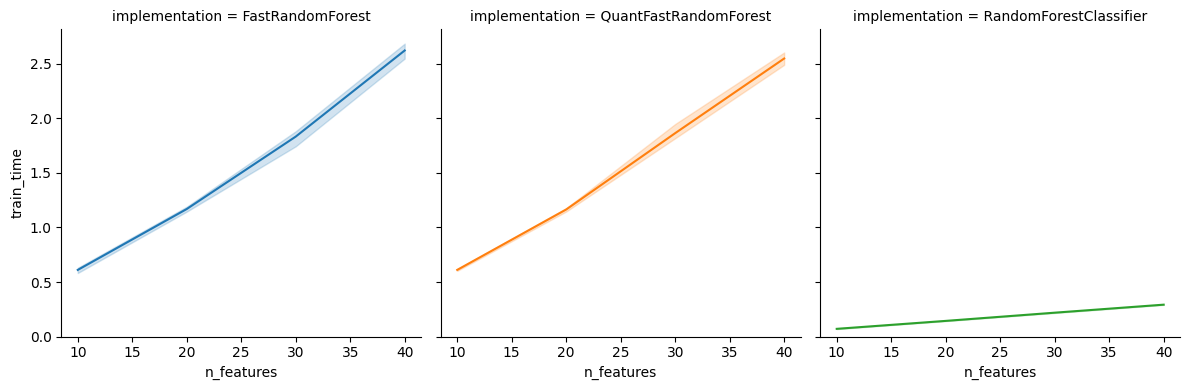

In [ ]:
import seaborn as sns

results = pd.read_csv('results/results_v08.csv')
g = sns.FacetGrid(data = results, col='implementation', sharey=True, height=4, hue='implementation')
g.map(sns.lineplot, 'n_features', "train_time")

# Ensure each facet's y-axis starts at 0
for ax in g.axes.flatten():
    ax.set_ylim(bottom=0)
